In [1]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [2]:
timeseries = data[["Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [3]:
import torch
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

/tmp/ipykernel_80118/2333354961.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X), torch.tensor(y)


In [4]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
train_data = TensorDataset(X_train, y_train)
loader = DataLoader(train_data, shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 226.5365, test RMSE 425.7749
Epoch 100: train RMSE 184.4960, test RMSE 381.8087
Epoch 200: train RMSE 151.6141, test RMSE 346.2800
Epoch 300: train RMSE 123.3607, test RMSE 313.9654
Epoch 400: train RMSE 98.7604, test RMSE 282.5003
Epoch 500: train RMSE 74.1738, test RMSE 246.8268
Epoch 600: train RMSE 57.3664, test RMSE 216.7673
Epoch 700: train RMSE 45.7227, test RMSE 191.7546
Epoch 800: train RMSE 37.4053, test RMSE 169.0562
Epoch 900: train RMSE 31.8329, test RMSE 150.1917
Epoch 1000: train RMSE 27.9890, test RMSE 134.2776
Epoch 1100: train RMSE 25.5615, test RMSE 121.2360
Epoch 1200: train RMSE 24.3592, test RMSE 110.4521
Epoch 1300: train RMSE 22.5900, test RMSE 102.6218
Epoch 1400: train RMSE 22.4163, test RMSE 95.2185
Epoch 1500: train RMSE 21.2360, test RMSE 90.7111
Epoch 1600: train RMSE 20.8739, test RMSE 86.9219
Epoch 1700: train RMSE 20.4373, test RMSE 84.2145
Epoch 1800: train RMSE 20.2493, test RMSE 81.4496
Epoch 1900: train RMSE 20.1340, test RMSE 80

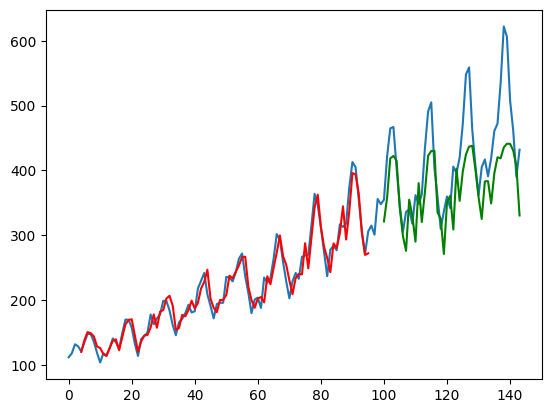

In [6]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()